In [14]:
import treecorr
import h5py
import pylab as mplot
import healpy as hp
import sacc
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/051422/12300area_nside4096/TXPipe_outputs/binned_lens_catalog.hdf5', "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    print(f['lens'].keys())
    # Get the data
    ra = np.array(f['lens/bin_0/ra'])
    dec = np.array(f['lens/bin_0/dec'])
    w = np.array(f['lens/bin_0/weight'])

Keys: <KeysViewHDF5 ['lens', 'provenance']>
<KeysViewHDF5 ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_all']>


In [ ]:
with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/051422/12300area_nside4096/TXPipe_outputs/binned_shear_catalog.hdf5', "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    print(f['shear/bin_0'].keys())
    print(f['shear'].keys())
    
    for i in range(5):
        # Get the data
        ra = np.array(f['shear/bin_'+str(i)+'/ra'])
        dec = np.array(f['shear/bin_'+str(i)+'/dec'])
        g1 = np.array(f['shear/bin_'+str(i)+'/g1'])
        g2 = np.array(f['shear/bin_'+str(i)+'/g2'])
        phi_shear = ra/180*np.pi
        theta_shear = (90.-dec)/180*np.pi
        pix_shear = hp.ang2pix(4096, theta_shear, phi_shear)
        
        g1_map = np.zeros(hp.nside2npix(4096))
        g2_map = np.zeros(hp.nside2npix(4096))
        N_map = np.zeros(hp.nside2npix(4096))
        
        for j in range(len(ra)):
            g1_map[pix_shear[j]] += g1[j]
            g2_map[pix_shear[j]] += g2[j]
            N_map[pix_shear[j]] += 1.
        
        mask_N = (N_map>0)
        g1_map[mask_N] /= N_map[mask_N]
        g2_map[mask_N] /= N_map[mask_N]
        
        # np.savez('/global/cscratch1/sd/chihway/shear_map_'+str(i)+'.npz', g1=g1_map, g2=g2_map)
    
    # w = np.array(f['lens/bin_0/weight'])

Keys: <KeysViewHDF5 ['provenance', 'shear']>
<KeysViewHDF5 ['dec', 'g1', 'g2', 'ra', 'weight']>
<KeysViewHDF5 ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_all']>


In [2]:
scale = np.array([2., 1.5, 1.25, 1.25, 1.25])

for lensi in range(5):
    print(lensi)
    
    with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/051422/12300area_nside4096/TXPipe_outputs/density_maps.hdf5', "r") as f:

        # Get the data
        pix = np.array(f['maps/delta_'+str(lensi)+'/pixel']) 
        delta = np.array(f['maps/delta_'+str(lensi)+'/value'])
        
    theta, phi = hp.pix2ang(4096, pix)
    dec_pix = 90.-theta/np.pi*180
    ra_pix = phi/np.pi*180
    mask_small_area = (ra_pix<500)
    
    
    # <NN>
    kk = treecorr.KKCorrelation(nbins=20,
                                min_sep=2.5,
                                max_sep=250.0,
                                sep_units='arcmin',
                                bin_slop=0.02)

    # cat_k1 = treecorr.Catalog(ra=ra_pix[mask_small_area], dec=dec_pix[mask_small_area], k=delta[mask_small_area], ra_units='deg', dec_units='deg')
    # kk.process(cat_k1, cat_k1)

    cat_k1 = treecorr.Catalog(ra=ra_pix[mask_small_area], dec=dec_pix[mask_small_area], k=delta[mask_small_area], ra_units='deg', dec_units='deg', npatch=50)
    kk.process(cat_k1, cat_k1)
    cov_jk = kk.estimate_cov('jackknife')

    theta      = np.exp(kk.logr)
    mean       = kk.xi
    weights_kk = kk.weight
    npairs_kk  = kk.npairs

    np.savez('wtheta_'+str(lensi)+'.npz', mean=mean.copy(), cov=cov_jk.copy())

4


In [6]:
with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/051422/12300area_nside4096/TXPipe_outputs/source_maps.hdf5', "r") as f:
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    print(f['maps/g1_0'].keys())

Keys: <KeysViewHDF5 ['maps', 'provenance']>
<KeysViewHDF5 ['pixel', 'value']>


In [13]:
sourcei=2
with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/051422/12300area_nside4096/TXPipe_outputs/source_maps.hdf5', "r") as f:
    pix_shear = np.array(f['maps/g1_'+str(sourcei)+'/pixel'])
    g1_pix = np.array(f['maps/g1_'+str(sourcei)+'/value'])
    g2_pix = np.array(f['maps/g2_'+str(sourcei)+'/value'])

(array([16073703.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 43905570.]),
 array([-1.63750000e+30, -1.47375000e+30, -1.31000000e+30, -1.14625000e+30,
        -9.82500000e+29, -8.18750000e+29, -6.55000000e+29, -4.91250000e+29,
        -3.27500000e+29, -1.63750000e+29,  1.37917527e+00]),
 <BarContainer object of 10 artists>)

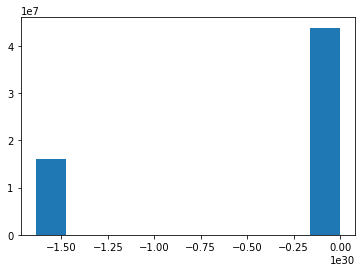

In [10]:
mplot.hist(g1_pix)

(array([2.236000e+03, 5.578000e+03, 1.317700e+04, 2.901200e+04,
        6.083500e+04, 1.192540e+05, 2.237810e+05, 4.012090e+05,
        6.935600e+05, 1.153510e+06, 1.843189e+06, 2.785323e+06,
        3.918965e+06, 5.007259e+06, 5.695604e+06, 5.695768e+06,
        5.006447e+06, 3.917865e+06, 2.785749e+06, 1.842709e+06,
        1.153869e+06, 6.931530e+05, 4.016430e+05, 2.226700e+05,
        1.195140e+05, 6.078500e+04, 2.920300e+04, 1.323800e+04,
        5.616000e+03, 2.259000e+03]),
 array([-1.        , -0.93333333, -0.86666667, -0.8       , -0.73333333,
        -0.66666667, -0.6       , -0.53333333, -0.46666667, -0.4       ,
        -0.33333333, -0.26666667, -0.2       , -0.13333333, -0.06666667,
         0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
         0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
         1.        ]),
 <BarContainer object of 30 artists>)

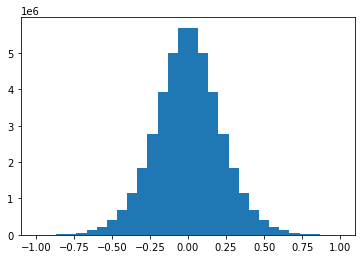

In [11]:
mplot.hist(g1_pix, range=(-1,1), bins=30)

In [ ]:
hp.mollview(g1_pix)

3
4
[2.19726562e-02 6.59179688e-02 1.09863281e-01 ... 3.59890137e+02
 3.59934082e+02 3.59978027e+02]
[2.19726562e-02 6.59179688e-02 1.53808594e-01 ... 3.59890137e+02
 3.59934082e+02 3.59978027e+02]


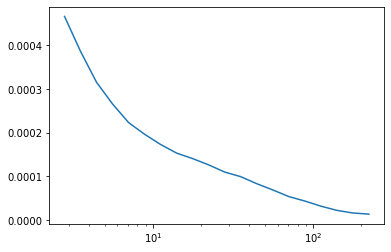

In [2]:
scale = np.array([2., 1.5, 1.25, 1.25, 1.25])

for lensi in range(3,4):
    print(lensi)
    
    with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/051422/12300area_nside4096/TXPipe_outputs/density_maps.hdf5', "r") as f:

        # Get the data
        pix = np.array(f['maps/delta_'+str(lensi)+'/pixel']) 
        delta = np.array(f['maps/delta_'+str(lensi)+'/value'])
        
    theta, phi = hp.pix2ang(4096, pix)
    dec_pix = 90.-theta/np.pi*180
    ra_pix = phi/np.pi*180
    mask_small_area = (ra_pix<500)
    
    for sourcei in range(4,5):
        print(sourcei)
        
        with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/051422/12300area_nside4096/TXPipe_outputs/source_maps.hdf5', "r") as f:
            pix_shear = np.array(f['maps/g1_'+str(sourcei)+'/pixel'])
            g1_pix = np.array(f['maps/g1_'+str(sourcei)+'/value'])
            g2_pix = np.array(f['maps/g2_'+str(sourcei)+'/value'])
            theta_pix_shear, phi_pix_shear = hp.pix2ang(4096, pix_shear)
            ra_pix_shear = phi_pix_shear/np.pi*180
            dec_pix_shear = 90. - theta_pix_shear/np.pi*180
            mask_small_area_shear = (ra_pix_shear<500)*(g1_pix>-1e30)*(g2_pix>-1e30)
        
        # g1_pix = hp.ud_grade(np.load('/global/cscratch1/sd/chihway/shear_map_'+str(sourcei)+'.npz')['g1'], 2048)
        # g2_pix = hp.ud_grade(np.load('/global/cscratch1/sd/chihway/shear_map_'+str(sourcei)+'.npz')['g2'], 2048)
        # pix_shear = np.arange(hp.nside2npix(2048))[g1_pix!=0]
        # theta_pix_shear, phi_pix_shear = hp.pix2ang(2048, pix_shear)
        # ra_pix_shear = phi_pix_shear/np.pi*180
        # dec_pix_shear = 90. - theta_pix_shear/np.pi*180
        # mask_small_area_shear = (ra_pix_shear<500)
        
    
        # <NG>
        kg = treecorr.KGCorrelation(nbins=20,
                                    min_sep=2.5,
                                    max_sep=250.0,
                                    sep_units='arcmin',
                                    bin_slop=0.04)

        cat_k = treecorr.Catalog(ra=ra_pix[mask_small_area], dec=dec_pix[mask_small_area], k=delta[mask_small_area], ra_units='deg', dec_units='deg')
        cat_g = treecorr.Catalog(ra=ra_pix_shear[mask_small_area_shear], dec=dec_pix_shear[mask_small_area_shear], 
                                 g1=-g1_pix[mask_small_area_shear], g2=g2_pix[mask_small_area_shear], 
                                 ra_units='deg', dec_units='deg')

        
        kg.process(cat_k, cat_g)
        theta      = np.exp(kg.logr)
        mean       = kg.xi
        print(ra_pix[mask_small_area])
        print(ra_pix_shear[mask_small_area_shear])

        
        TXPipe = sacc.Sacc.load_fits('twopoint_theory_real.sacc')
        theta3, xi = TXPipe.get_theta_xi(
            'galaxy_shearDensity_xi_t',
            'source_'+str(sourcei),'lens_'+str(lensi))

        
        mplot.semilogx(theta, mean*scale[lensi])
        # mplot.semilogx(theta3, xi)
        
        mplot.show()

        np.savez('gammat_'+str(lensi)+'_'+str(sourcei)+'.npz', mean=mean.copy())
        

[('lens_0', 'lens_0'), ('lens_1', 'lens_0'), ('lens_1', 'lens_1'), ('lens_2', 'lens_0'), ('lens_2', 'lens_1'), ('lens_2', 'lens_2'), ('lens_3', 'lens_0'), ('lens_3', 'lens_1'), ('lens_3', 'lens_2'), ('lens_3', 'lens_3'), ('lens_4', 'lens_0'), ('lens_4', 'lens_1'), ('lens_4', 'lens_2'), ('lens_4', 'lens_3'), ('lens_4', 'lens_4'), ('source_0', 'lens_0'), ('source_0', 'lens_1'), ('source_0', 'lens_2'), ('source_0', 'lens_3'), ('source_0', 'lens_4'), ('source_1', 'lens_0'), ('source_1', 'lens_1'), ('source_1', 'lens_2'), ('source_1', 'lens_3'), ('source_1', 'lens_4'), ('source_2', 'lens_0'), ('source_2', 'lens_1'), ('source_2', 'lens_2'), ('source_2', 'lens_3'), ('source_2', 'lens_4'), ('source_3', 'lens_0'), ('source_3', 'lens_1'), ('source_3', 'lens_2'), ('source_3', 'lens_3'), ('source_3', 'lens_4'), ('source_4', 'lens_0'), ('source_4', 'lens_1'), ('source_4', 'lens_2'), ('source_4', 'lens_3'), ('source_4', 'lens_4'), ('source_0', 'source_0'), ('source_1', 'source_0'), ('source_1', 'sou

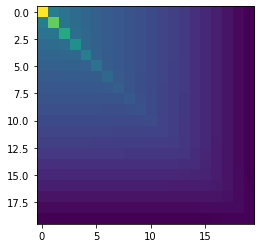

In [19]:
TXPipe_cov = sacc.Sacc.load_fits('summary_statistics_real_scaled_shot_noise.sacc')

print(TXPipe_cov.get_tracer_combinations())
mplot.imshow(TXPipe_cov.covariance.covmat[:20,:20])

fsky_all = 12300./(4*np.pi/np.pi**2*180**2)
fsky_small = len(ra_pix[mask_small_area])*1.0/hp.nside2npix(4096)



with scale cuts bin0 chi2/dof= 1.0762543179753163
without scale cuts bin0 chi2/dof= 1.836002338150583
with scale cuts bin1 chi2/dof= 0.3354583197768528
without scale cuts bin1 chi2/dof= 1.688811548874605
with scale cuts bin2 chi2/dof= 0.7019536430107773
without scale cuts bin2 chi2/dof= 1.3889778787580975
with scale cuts bin3 chi2/dof= 0.5313662362319028
without scale cuts bin3 chi2/dof= 0.9943166208699796
with scale cuts bin4 chi2/dof= 0.32706689727953087
without scale cuts bin4 chi2/dof= 0.38565978204955836


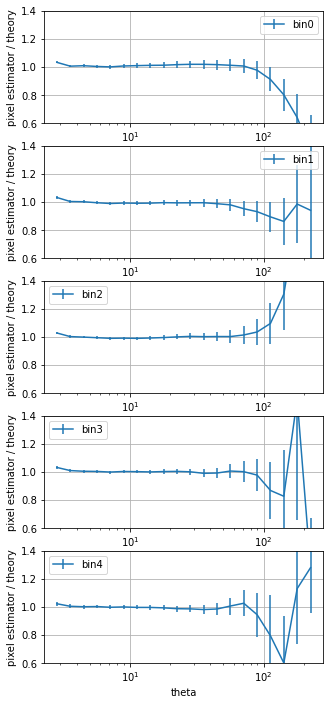

In [3]:
mplot.figure(figsize=(5,12))
scale = np.array([2., 1.5, 1.25, 1.25, 1.25])
order = np.array([0,2,5,9,14])
TXPipe_cov = sacc.Sacc.load_fits('summary_statistics_real_scaled_shot_noise.sacc')

for i in range(5):
    
    with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/051422/12300area_nside4096/TXPipe_outputs/density_maps.hdf5', "r") as f:

        # Get the data
        pix2 = np.array(f['maps/delta_'+str(i)+'/pixel']) 
        
    theta2, phi2 = hp.pix2ang(4096, pix2)
    dec_pix2 = 90.-theta2/np.pi*180
    ra_pix2 = phi2/np.pi*180
    mask_small_area2 = (ra_pix2<500)
    

    fsky_all = 12300./(4*np.pi/np.pi**2*180**2)
    fsky_small = len(ra_pix2[mask_small_area2])*1.0/hp.nside2npix(4096)
    cov_ana = TXPipe_cov.covariance.covmat[20*order[i]:20*(order[i]+1),20*order[i]:20*(order[i]+1)]
    #*fsky_all/fsky_small
    #print(fsky_all/fsky_small)

    
    TXPipe = sacc.Sacc.load_fits('twopoint_theory_real.sacc')
    theta3, xi = TXPipe.get_theta_xi(
        'galaxy_density_xi',
        'lens_'+str(i),
        'lens_'+str(i))
    
    wtheta = np.load('wtheta_'+str(i)+'.npz')['mean']
    # cov = np.load('wtheta_'+str(i)+'.npz')['cov']

    mplot.subplot(5,1,i+1)
    mplot.errorbar(theta3, wtheta*scale[i]**2/xi, yerr=np.diag(cov_ana)**0.5/xi, label='bin'+str(i))
    mplot.legend()
    mplot.xscale('log')
    mplot.xlabel('theta')
    mplot.ylabel('pixel estimator / theory')
    mplot.ylim(0.6,1.4)
    mplot.grid()
    
    nn = [10,8,7,7,6]
    
    # nn = [1,1,0,0,0]
    
    chi2 = np.dot(np.dot((wtheta[nn[i]:]*scale[i]**2-xi[nn[i]:]),np.linalg.inv(cov_ana[nn[i]:,nn[i]:])),(wtheta[nn[i]:]*scale[i]**2-xi[nn[i]:]).T)
    print('with scale cuts bin'+str(i),'chi2/dof=', chi2/(20-nn[i]))

    chi2 = np.dot(np.dot((wtheta*scale[i]**2-xi),np.linalg.inv(cov_ana)),(wtheta*scale[i]**2-xi).T)
    print('without scale cuts bin'+str(i),'chi2/dof=', chi2/20)

mplot.savefig('wtheta.png')

with scale cuts bin0/2 chi2/dof= 1.0055291570734477
without scale cuts bin0/2 chi2/dof= 2.0164278314129755
with scale cuts bin0/3 chi2/dof= 1.2759424394728645
without scale cuts bin0/3 chi2/dof= 2.39922769012788
with scale cuts bin0/4 chi2/dof= 0.8045204047875419
without scale cuts bin0/4 chi2/dof= 1.878697086961455
with scale cuts bin1/3 chi2/dof= 1.070697225184861
without scale cuts bin1/3 chi2/dof= 1.3186925087200774
with scale cuts bin1/4 chi2/dof= 1.104727019249316
without scale cuts bin1/4 chi2/dof= 2.821014807480013
with scale cuts bin2/4 chi2/dof= 0.3875196297361976
without scale cuts bin2/4 chi2/dof= 2.0256662867554063
with scale cuts bin3/4 chi2/dof= 0.3112914244141153
without scale cuts bin3/4 chi2/dof= 1.0317181717934252


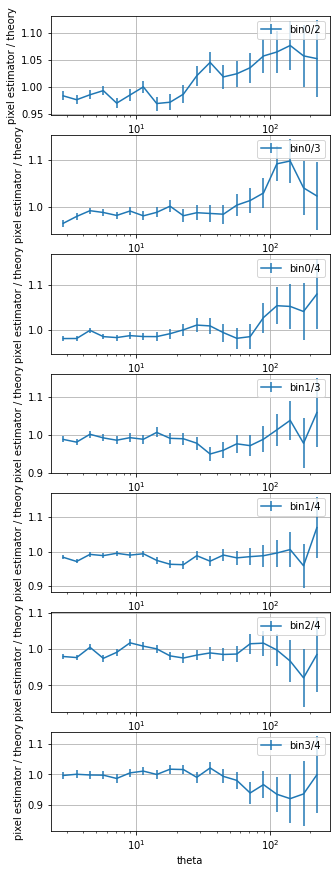

In [19]:
mplot.figure(figsize=(5,15))

lensi=[0,0,0,1,1,2,3]
sourcei=[2,3,4,3,4,4,4]
order = np.array([25,30,35,31,36,37,38])
scale = np.array([2.,2,2,1.5,1.5,1.25,1.25])

# TXPipe_cov = sacc.Sacc.load_fits('summary_statistics_real_scaled_shot_noise.sacc')
TXPipe_cov = sacc.Sacc.load_fits('/global/cscratch1/sd/chihway/summary_statistics_real_onlycovOK.sacc')

for ii in range(7):
        
    cov_ana = TXPipe_cov.covariance.covmat[20*order[ii]:20*(order[ii]+1),20*order[ii]:20*(order[ii]+1)]

    TXPipe = sacc.Sacc.load_fits('twopoint_theory_real.sacc')
    theta3, xi = TXPipe.get_theta_xi(
        'galaxy_shearDensity_xi_t',
        'source_'+str(sourcei[ii]),'lens_'+str(lensi[ii]))

    gammat = np.load('gammat_'+str(lensi[ii])+'_'+str(sourcei[ii])+'.npz')['mean']

    mplot.subplot(7,1,ii+1)
    mplot.errorbar(theta3, gammat*scale[ii]/xi, yerr=np.diag(cov_ana)**0.5/xi, label='bin'+str(lensi[ii])+'/'+str(sourcei[ii]))
    # mplot.errorbar(theta3, xi)
    mplot.legend()
    mplot.xscale('log')
    # mplot.yscale('log')
    mplot.xlabel('theta')
    mplot.ylabel('pixel estimator / theory')
    # mplot.ylim(0.6,1.4)
    mplot.grid()

    scale_cuts_srd = [21.55989864, 21.55989864, 21.55989864, 13.56648461, 13.56648461, 10.18231511, 8.32631607] # in arcmin
    # nn = [5,5,5,5,5,5,5]
    nn=len(gammat[theta3<scale_cuts_srd[ii]])
    chi2 = np.dot(np.dot((gammat[-nn:]*scale[ii]-xi[-nn:]),np.linalg.inv(cov_ana[-nn:,-nn:])),(gammat[-nn:]*scale[ii]-xi[-nn:]).T)
    print('with scale cuts bin'+str(lensi[ii])+'/'+str(sourcei[ii]),'chi2/dof=', chi2/(nn))

    chi2 = np.dot(np.dot((gammat*scale[ii]-xi),np.linalg.inv(cov_ana)),(gammat*scale[ii]-xi).T)
    print('without scale cuts bin'+str(lensi[ii])+'/'+str(sourcei[ii]),'chi2/dof=', chi2/20)

mplot.savefig('gammat.png')

In [7]:
help(TXPipe.get_theta_xi)

Help on method get_theta_xi in module sacc.sacc:

get_theta_xi(data_type, tracer1, tracer2, return_cov=False, return_ind=False) method of sacc.sacc.Sacc instance
    Helper method to extract the theta and correlation function
    values for a specific data type (e.g. 'shear_xi' and pair of
    tomographic bins).
    
    Parameters
    ----------
    
    data_type: str
        Which type of xi to extract
    
    tracer1: str
        The name of the first tracer, for example a tomographic bin name
    
    tracer2: str
        The name of the second tracer
    
    return_cov: bool
        If True, also return the block of the covariance
        corresponding to these points.  Default=False
    
    return_ind: bool
        If True, also return the datapoint indices. Default=False
    
    Returns
    -------
    ell: array
        Ell values for this tracer pair
    
    mu: array
        Mean values for this tracer pair
    
    cov_block: 2D array
        (Only if return_cov=True) 